# Installing / Importing Libraries

In [1]:
import pandas as pd
from pandas import to_datetime
import numpy as np
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

from numpy import array

In [2]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data

In [3]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [4]:
Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)
Daily_data

,Inquiries_NonStat
date,
2017-01-01,7574.0
2017-01-02,13189.0
2017-01-03,24678.0
2017-01-04,23380.0
2017-01-05,22809.0
...,...
2022-09-26,13039.0
2022-09-27,11598.0
2022-09-28,11886.0


In [5]:
sample_Daily_data = Daily_data.loc['2020-01-01':]
sample_Daily_data

,Inquiries_NonStat
date,
2020-01-01,6910.0
2020-01-02,17788.0
2020-01-03,16334.0
2020-01-04,7812.0
2020-01-05,7158.0
...,...
2022-09-26,13039.0
2022-09-27,11598.0
2022-09-28,11886.0


In [6]:
Daily_data.isna().any()

Inquiries_NonStat    False
dtype: bool

In [7]:
Daily_data.describe()

,Inquiries_NonStat
count,2099.000000
mean,14240.924250
std,5809.277724
min,406.000000
25%,9739.500000
50%,13864.000000
75%,19310.000000
max,30619.000000


C:\Users\manal\AppData\Local\Temp\ipykernel_54504\3351443599.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Daily_data.drop(Daily_data.columns.difference(['Inquiries_NonStat']),1, inplace=True)


<AxesSubplot: xlabel='date'>

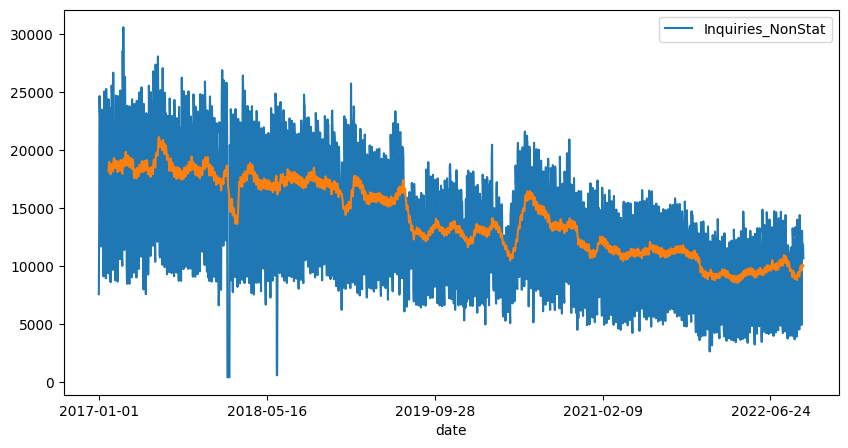

In [8]:
Daily_data.drop(Daily_data.columns.difference(['Inquiries_NonStat']),1, inplace=True)
Daily_data.plot()
Daily_data.rolling(window=30).mean()['Inquiries_NonStat'].plot()

Average of 30 days

In [9]:
Daily_data = Daily_data.reset_index('date')
Daily_data['date'] = pd.to_datetime(Daily_data['date'])
Daily_data = Daily_data.set_index('date')

In [10]:
sample_Daily_data = Daily_data.loc['2020-01-01':'2020-03-01']
sample_Daily_data
sample_Daily_data = sample_Daily_data.reset_index('date')
sample_Daily_data['date'] = pd.to_datetime(sample_Daily_data['date'])
sample_Daily_data = sample_Daily_data.set_index('date')

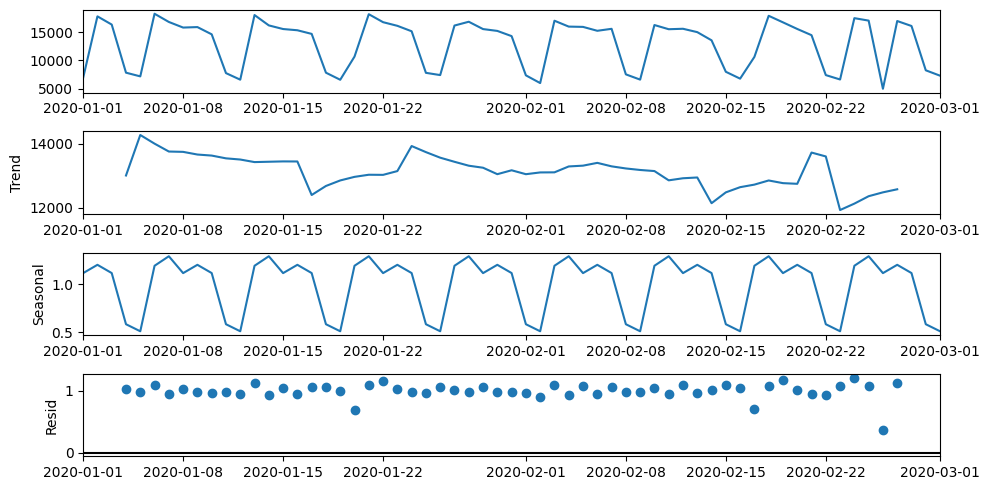

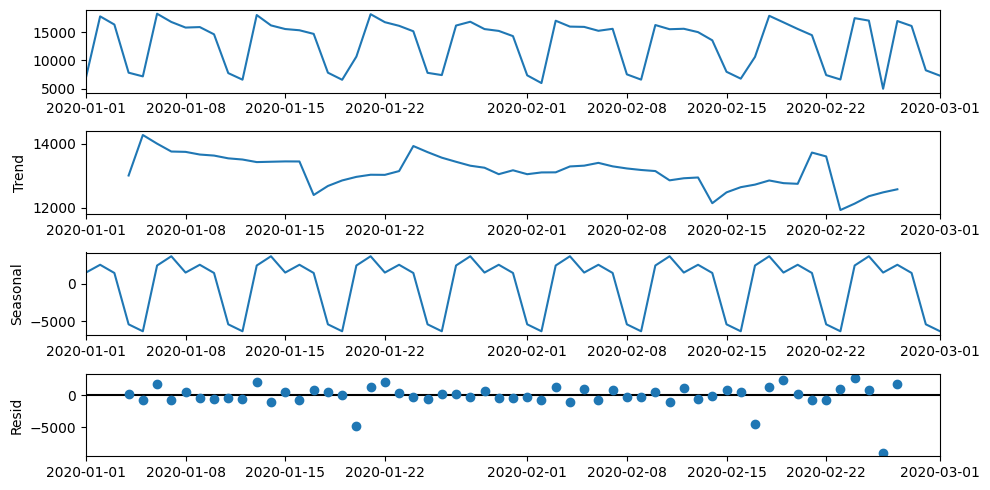

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(sample_Daily_data, model='multipicative') # T*S*R = Observed
resplot = res.plot()
res2 = seasonal_decompose(sample_Daily_data, model='additive') # T+S+R = Observed
resplot = res2.plot()

# Splitting the data into 80:20 ratio

In [12]:
train_df = Daily_data.iloc[:1680]
test_df  = Daily_data.iloc[1679:]

In [13]:
train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

# Holt-Winters Model with Training Data

In [14]:
data = train_df.values

y_prediction = []
for t in test_df.values:
    filterwarnings("ignore")
    ES_model = ExponentialSmoothing(data, trend='add', seasonal= 'add', seasonal_periods=7)
    ES_results = ES_model.fit()
    y = ES_results.forecast()
    y_prediction.append(y[0])
    data = np.append(data, t)

In [15]:

print(ES_results.summary().tables[1])

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2878571                alpha                 True
smoothing_trend                  0.0001                 beta                 True
smoothing_seasonal            0.1186905                gamma                 True
initial_level                 19030.086                  l.0                 True
initial_trend                -54.441558                  b.0                 True
initial_seasons.0            -8988.8480                  s.0                 True
initial_seasons.1             3416.3306                  s.1                 True
initial_seasons.2             5232.0092                  s.2                 True
initial_seasons.3             3694.8378                  s.3                 True
initial_seasons.4             3595.2235                  s.4                 True
initial_seasons.

In [16]:
test_ = pd.DataFrame(test_df)
test_['predictions'] = y_prediction

In [17]:
test_ = test_.dropna()
test_.isna().any()

Inquiries_NonStat    False
predictions          False
dtype: bool

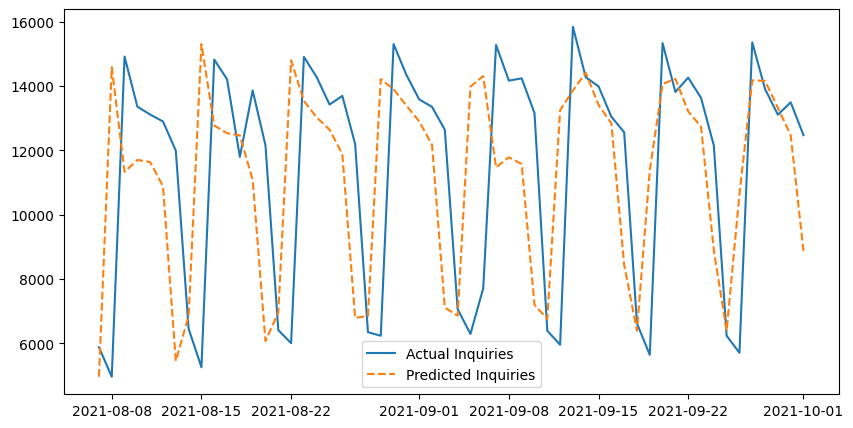

In [18]:
plt.plot(test_.loc['2021-08-07':'2021-10-01']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_.loc['2021-08-07':'2021-10-01'].predictions, '--', label = 'Predicted Inquiries')
plt.legend()

In [19]:
test_

,Inquiries_NonStat,predictions
date,,
2021-08-07,5879.0,4959.161739
2021-08-08,4960.0,14587.276270
2021-08-09,14917.0,11332.230633
2021-08-10,13359.0,11703.197843
2021-08-11,13114.0,11636.263376
...,...,...
2022-09-26,13039.0,12094.997823
2022-09-27,11598.0,13283.561876
2022-09-28,11886.0,12202.028959


# Evaluating Prediction

In [20]:
error = np.round(np.sqrt(mean_squared_error(test_.Inquiries_NonStat,test_.predictions)), decimals = 3)
print ('Test RMSE for Triple Exponential Smoothing with Walk-Forward Validation: ', error)

Test RMSE for Triple Exponential Smoothing with Walk-Forward Validation:  1987.469


<AxesSubplot: xlabel='date'>

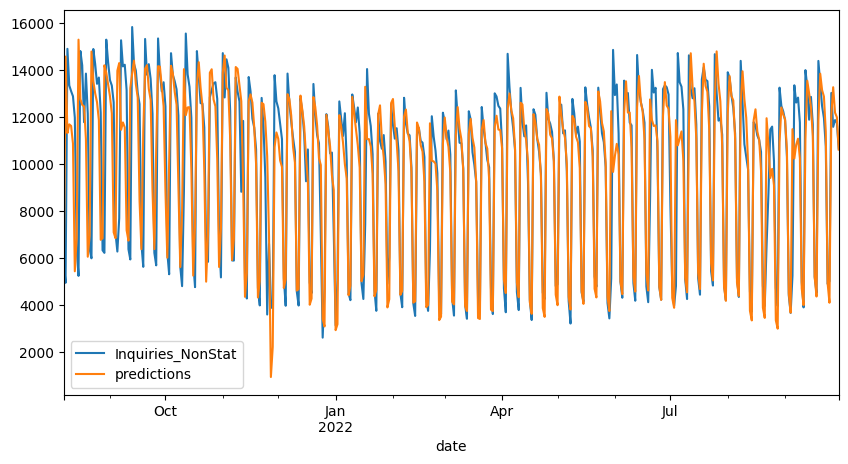

In [21]:
test_.plot()

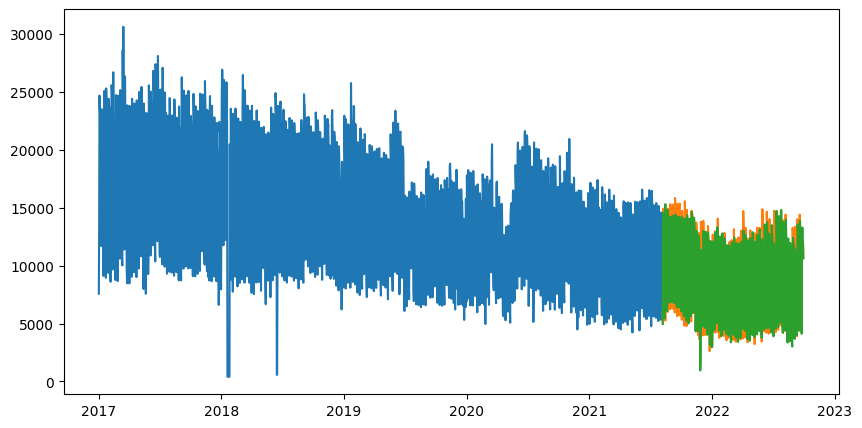

In [22]:
plt.plot(train_df)
plt.plot(test_df)
test_['predictions']
plt.show()

# Hyperparameter Tuning

In [23]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = [1, 3, 7, None]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[['add', True, 'add', 3, True]] 4601.260
 > Model[['add', True, 'add', 3, False]] 4595.292
 > Model[['add', True, 'add', 7, True]] 1893.099
 > Model[['add', True, 'add', 7, False]] 1892.083
 > Model[['add', True, 'mul', 3, True]] 4599.672
 > Model[['add', True, 'mul', 3, False]] 4594.077
 > Model[['add', True, 'mul', 7, True]] 1915.557
 > Model[['add', True, 'mul', 7, False]] 1914.408
 > Model[['add', True, None, 1, True]] 4591.646
 > Model[['add', True, None, 1, False]] 4585.717
 > Model[['add', True, None, 3, True]] 4591.646
 > Model[['add', True, None, 3, False]] 4585.717
 > Model[['add', True, None, 7, True]] 4591.646
 > Model[['add', True, None, 7, False]] 4585.717
 > Model[['add', True, None, None, True]] 4591.646
 > Model[['add', True, None, None, False]] 4585.717
 > Model[['add', False, 'add', 3, True]] 4612.306
 > Model[['add', False, 'add', 3, False]] 4607.969
 > Model[['add', False, 'add', 7, True]] 1895.965
 > Model[['add', False, 'add', 7, False]] 1899.057
 > Model

In [25]:
len(scores)

76

In [32]:
header = "Trend, DampedTrend, Seasonality, SeasonalPeriods, Remove_bias"

with open('results.txt', 'w') as f:
    f.write(header + "\n")
    for s in scores:
        f.write(str(s) + '\n')
    f.close

In [34]:
for cfg, error in scores[:10]:
	print("Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error")
	print(cfg, error)

Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
[None, False, 'add', 7, False] 1889.2183955841037
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
[None, False, 'add', 7, True] 1890.2372655588824
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['mul', True, 'mul', 7, False] 1891.791693354095
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['add', True, 'add', 7, False] 1892.0833330637552
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['add', True, 'add', 7, True] 1893.098503862594
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['add', False, 'add', 7, True] 1895.9653289816397
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['add', False, 'add', 7, False] 1899.0567428647103
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['mul', True, 'add', 7, False] 1909.741981569468
Trend, Damped, Seasonality, SeasonalPeriods, Remove_bias,Error
['add', True, 'mul', 7, False] 1914.4